In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session
%matplotlib inline

# fix slow autocomplete
%config Completer.use_jedi = False

In [39]:
# manifest_path = os.path.join('/local1/storage/allensdk_cache/example_ecephys_project_cache', 'manifest.json')
manifest_path = r'/Volumes/Brain2018/Neuropixels/manifest.json'
# manifest_path = r'/Volumes/aibs/informatics/nileg/swdb_ecephys/_cache_dir/manifest.json'

# manifest_path = os.path.join(
#     "/",
#     "allen",
#     "aibs",
#     "informatics",
#     "nileg",
#     "swdb_ecephys",
#     "cache_dir",
#     "manifest.json"
# )

lims_config = {
    "pg_kwargs": {
        "dbname": "lims2_nileg",
        "host": "aibsdc-dev-db1",
        "port": 5432,
        "user": "limsreader",
        "password": "limsro"
    },
    "app_kwargs": {
        "host": "10.128.50.64:3000"
    }
}

cache = EcephysProjectCache.from_lims(manifest=manifest_path, lims_kwargs=lims_config)

In [40]:
swdb_ids = set([
    732592105,
    737581020,
    739448407,
    744228101,
    746083955,
    750332458,
    750749662,
    751348571,
    754312389,
    754829445,
    755434585,
    756029989,
    757216464,
    757970808,
    758798717,
    759883607,
    760345702,
    760693773,
    761418226,
    762120172,
    762602078,
    773418906,
])


# Exploring an experimental session

To find the available sessions, we use the <b>session</b> object. This is a dataframe of all the sessions that have passed QC.  WE NEED TO USE A DIFFERENT NAME

In [41]:
sessions = cache.get_sessions()
sessions = sessions[
    (sessions.index.isin(swdb_ids))
    & (sessions["has_nwb"])
]

In [42]:
sessions.head()

,session_type,specimen_id,genotype,gender,age_in_days,project_code,probe_count,channel_count,unit_count,has_nwb,structure_acronyms
id,,,,,,,,,,,
737581020,brain_observatory_1.1,718643567,wt,M,108.0,NeuropixelVisualCoding,6,797,1833,True,"[CA, DG, MB, TH, VISl, VISmma, VISp, VISpm, VI..."
739448407,brain_observatory_1.1,716813543,wt,M,112.0,NeuropixelVisualCoding,6,815,2129,True,"[CA, DG, MB, TH, VIS, VISam, VISl, VISp, VISrl..."
744228101,brain_observatory_1.1,719817805,wt,M,122.0,NeuropixelVisualCoding,6,900,2399,True,"[CA, DG, MB, TH, VIS, VISal, VISl, VISp, VISrl..."
746083955,brain_observatory_1.1,726170935,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,98.0,NeuropixelVisualCoding,6,754,1889,True,"[CA, DG, MB, TH, VISal, VISl, VISp, VISpm, VIS..."
750749662,brain_observatory_1.1,726162197,wt,M,92.0,NeuropixelVisualCoding,6,920,2308,True,"[CA, DG, MB, TH, VISal, VISam, VISl, VISp, VIS..."


How many sessions are available?

In [43]:
len(sessions)

18

What's the average number of units in a session? The max? The min?

In [44]:
print(sessions.unit_count.mean())
print(sessions.unit_count.max())
print(sessions.unit_count.min())

2049.222222222222
2597
1610


What are the different genotypes that were used for this dataset? How many sessions per genotype are available?

In [45]:
sessions.genotype.value_counts()

wt                                                 8
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      4
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      3
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    3
Name: genotype, dtype: int64

How many sessions have data from VISp?

In [11]:
count=0
for index,row in sessions.iterrows():
    if 'VISp' in row.structure_acronyms:
        count+=1
print(count)

18


What are all the structures that data has been collected from?

In [12]:
all_areas = []
for index,row in sessions.iterrows():
    for a in row.structure_acronyms:
        if a not in all_areas:
            all_areas.append(a)

In [13]:
all_areas

['CA',
 'DG',
 'MB',
 'TH',
 'VISl',
 'VISmma',
 'VISp',
 'VISpm',
 'VISrl',
 None,
 'VIS',
 'VISam',
 'VISal',
 'VISmmp']

Let's pick one session to examine in greater detail. Use some of these metadata to select a session.

In [14]:
session_id = sessions[(sessions.unit_count>2000)].index[0]
print(session_id)

739448407


Which areas were recorded from in this session?

In [15]:
sessions.structure_acronyms[session_id]

['CA', 'DG', 'MB', 'TH', 'VIS', 'VISam', 'VISl', 'VISp', 'VISrl', None]

## Getting data for a session

We can get the <b>session</b> object for this session. This object contains the data that is stored in the NWB file.

In [16]:
session = cache.get_session_data(session_id)

### Units

To begin, let's look at the <b>units</b> in this session. This is a dataframe of all the sorted units that pass QC for this experiment with some relevant information.

In [17]:
session.units.head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,channel_local_index,structure_acronym,structure_id,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,lfp_sampling_rate,location,sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,
914602976,0.346582,100.057815,0.026085,5,137.52,3.335647,31.839506,0.024853,95.979386,0.036386,...,13,TH,549.0,11,757968489,140,probeA,2499.99703,,29999.964361
914602974,0.684731,120.798210,0.043860,4,200.04,3.853885,28.346921,0.008103,69.787442,0.070177,...,13,TH,549.0,11,757968489,140,probeA,2499.99703,,29999.964361
914602978,0.189503,76.722945,0.023672,6,310.35,3.862677,0.279998,0.000000,41.314878,0.006293,...,17,TH,549.0,11,757968489,180,probeA,2499.99703,,29999.964361
914602984,1.166022,69.630405,0.023543,9,260.19,5.897170,4.155625,0.028102,95.849442,0.000610,...,16,TH,549.0,43,757968489,180,probeA,2499.99703,,29999.964361
914602994,0.527284,122.473455,0.003017,14,188.33,4.807625,9.868341,0.015365,71.310975,0.003246,...,37,TH,549.0,11,757968489,380,probeA,2499.99703,,29999.964361


In [18]:
session.units.keys()

Index(['PT_ratio', 'amplitude', 'amplitude_cutoff', 'cluster_id',
       'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations',
       'isolation_distance', 'l_ratio', 'local_index_unit', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio',
       'recovery_slope', 'repolarization_slope', 'silhouette_score', 'snr',
       'spread', 'velocity_above', 'velocity_below', 'waveform_duration',
       'waveform_halfwidth', 'channel_local_index', 'structure_acronym',
       'structure_id', 'probe_horizontal_position', 'probe_id',
       'probe_vertical_position', 'probe_description', 'lfp_sampling_rate',
       'location', 'sampling_rate'],
      dtype='object')

## Not sure what these are or how a user would use them: cluster_id, local_index_unit, channel_local_index

## A lot of new things on here. We need to know what these are!!

## We need to be able to explain each of these items, where they came from, how to use them. Also need precise definitions for SNR and isi violations.

How many units are in this session?

In [22]:
len(session.units)

654

Which areas (structures) are they from?

In [23]:
print(session.units.structure_acronym.unique())

['TH' 'DG' 'CA' 'VISam' 'MB' 'VIS' 'VISp' 'VISl' 'VISrl']


***Nile add link to brainmap.org for a specific structure acronym***

how many units per area are there?

In [24]:
session.units.structure_acronym.value_counts()

CA       147
TH       126
VIS      100
VISrl     71
DG        64
VISam     58
VISl      36
MB        33
VISp      19
Name: structure_acronym, dtype: int64

The units dataframe has a number of metrics that are used to evaluate the quality of the units that we can use to select units for inclusion. We typically use the SNR and the ISI violations. NEED TO EXPLAIN WHAT THESE ARE.

Plot a histogram of SNR

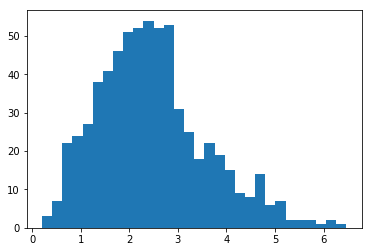

In [47]:
plt.hist(session.units.snr, bins=30);

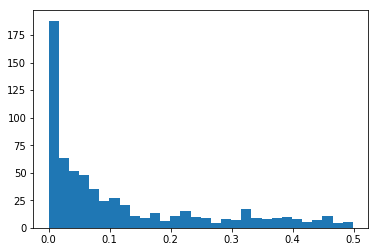

In [48]:
plt.hist(session.units.isi_violations, bins=30);

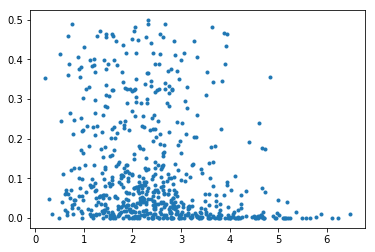

In [49]:
plt.plot(session.units.snr, session.units.isi_violations, '.')

A good default is to include units that have a SNR>1 and ISI violations<0.5  How many units meet these criteria? How many per structure?

In [50]:
len(session.units[(session.units.snr>1)&(session.units.isi_violations<0.5)])

601

In [51]:
session.units[(session.units.snr>1)&(session.units.isi_violations<0.5)].structure_acronym.value_counts()

CA       138
TH       123
VIS       92
VISrl     65
VISam     58
DG        49
MB        33
VISl      24
VISp      19
Name: structure_acronym, dtype: int64

### Spike times

Now let's look at the spike times for these units.

In [52]:
spike_times = session.spike_times

What type of object is this?

In [53]:
type(spike_times)

dict

How many items does it include?

In [54]:
len(spike_times)

654

In [55]:
len(session.units)

654

What are the keys for this object?

In [17]:
list(spike_times.keys())[:5]

[914619899, 914619907, 914619913, 914619929, 914619923]

Use the unit_id for the first unit to get the spike times for that unit. How many spikes does it have in the entire session?

In [56]:
spike_times[session.units.index[0]]

array([6.12474493e-01, 6.61541218e-01, 7.58474666e-01, ...,
       9.26842798e+03, 9.26844595e+03, 9.26847992e+03])

In [57]:
print(len(spike_times[session.units.index[0]]))

295086


Make a raster plot for the first 50 units

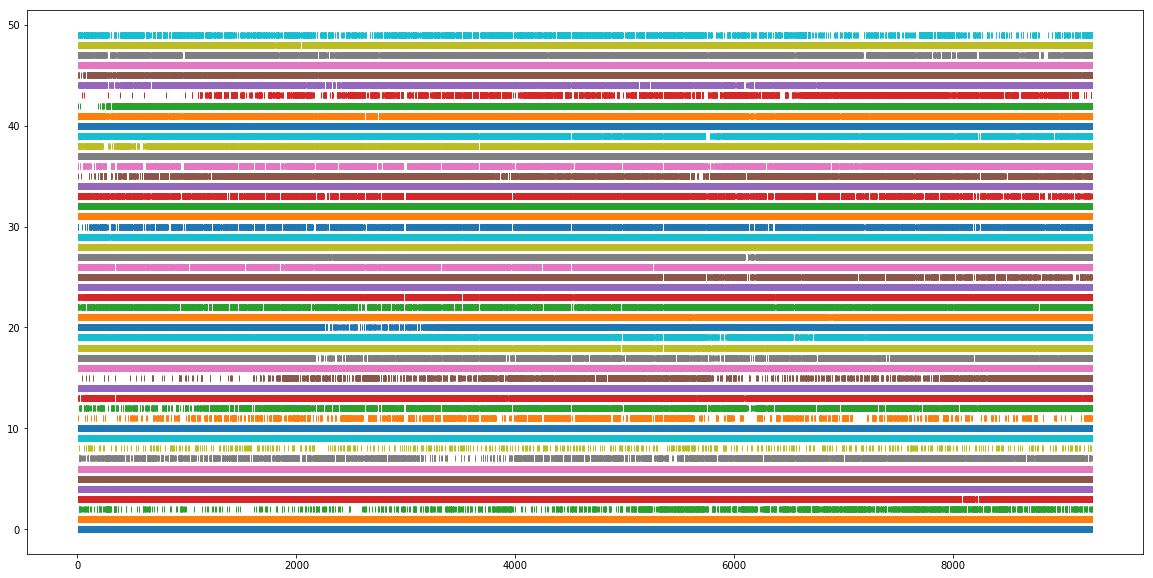

In [59]:
plt.figure(figsize=(20,10))
for i in range(50):
    plt.plot(spike_times[session.units.index[i]], np.repeat(i,len(spike_times[session.units.index[i]])), '|')#, color='gray')
# plt.xlim(2000,2250)

### Stimulus presentations

So far we've found the neural activity of the units in the dataset. Now let's look at the stimulus information. What stimuli were presented in this session?

In [60]:
session.stimulus_names

/Users/saskiad/anaconda2/envs/ecephys/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


['spontaneous_activity',
 'gabor_20_deg_250ms',
 'flash_250ms',
 'drifting_gratings',
 'natural_movie_3',
 'natural_movie_1',
 'static_gratings',
 'Natural Images']

## need to fix the stimulus names!!!

These stimuli are interleaved throughout the session. We can use the <b>stimulus epochs</b> to see when each type of stimulus was presented

In [63]:
stimulus_epochs = session.get_stimulus_epochs()
stimulus_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
1,88.684670,1000.679642,911.994972,gabor_20_deg_250ms,0.0
2,1000.679642,1289.671030,288.991388,spontaneous_activity,NaN
3,1289.671030,1588.170410,298.499380,flash_250ms,1.0
5,1589.921850,2189.439290,599.517440,drifting_gratings,2.0
7,2220.465190,2820.966760,600.501570,natural_movie_3,3.0
9,2850.991870,3151.242640,300.250770,natural_movie_1,4.0
11,3181.267700,3780.768460,599.500760,drifting_gratings,5.0
12,3780.768460,4082.020070,301.251610,spontaneous_activity,NaN
13,4082.020070,4682.538310,600.518240,natural_movie_3,6.0
15,4712.563410,5402.139340,689.575930,drifting_gratings,7.0


We can add this information to our plot from above by shading each stimulus with a unique color. The plt.axvspan() is a useful function for this.

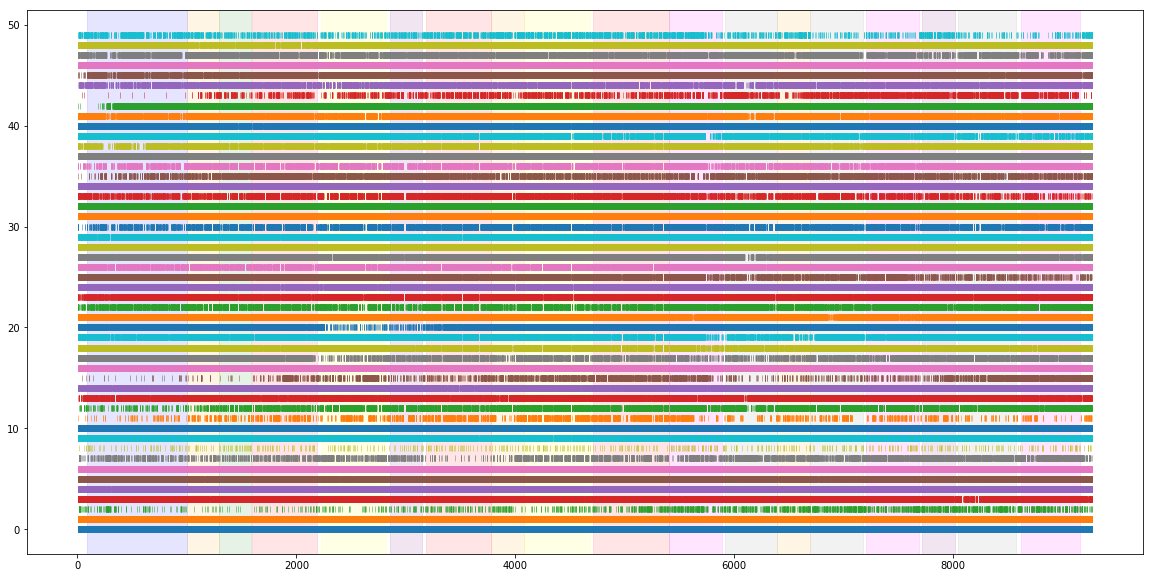

In [64]:
plt.figure(figsize=(20,10))
for i in range(50):
    plt.plot(spike_times[session.units.index[i]], np.repeat(i,len(spike_times[session.units.index[i]])), '|', alpha=0.5)#, color='gray')

colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c,stim_name in enumerate(stimulus_epochs["stimulus_name"].unique()):
    stim = stimulus_epochs[stimulus_epochs["stimulus_name"] == stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)
# plt.xlim(6000,7000)

Before we dig into the stimulus information in more detail, let's find one more piece of session-wide data that's in the dataset. Running speed.

### Get the running speed

Text(0, 0.5, 'Running speed (cm/s)')

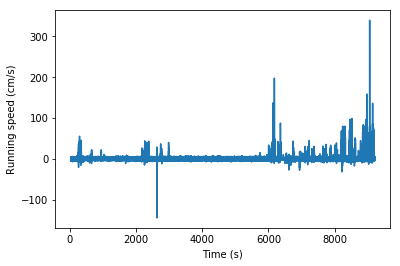

In [70]:
plt.plot(session.running_speed.end_time, session.running_speed.velocity)
plt.xlabel("Time (s)")
plt.ylabel("Running speed (cm/s)")

Add the running speed to the visualization. 

(-35, 52)

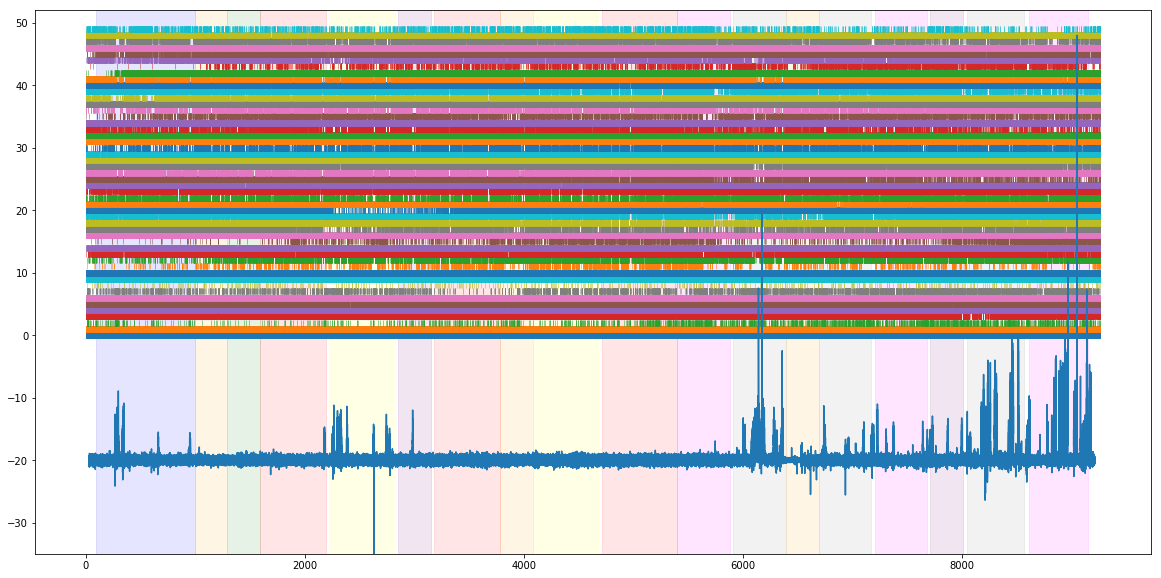

In [69]:
plt.figure(figsize=(20,10))
for i in range(50):
    plt.plot(spike_times[session.units.index[i]], np.repeat(i,len(spike_times[session.units.index[i]])), '|', alpha=0.5)#, color='gray')
plt.plot(session.running_speed.end_time, (0.2*session.running_speed.velocity)-20)
    
colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c,stim_name in enumerate(stimulus_epochs["stimulus_name"].unique()):
    stim = stimulus_epochs[stimulus_epochs["stimulus_name"]==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)
        

plt.ylim(-35,52)
# plt.xlim(6000,8000)

(6000, 8000)

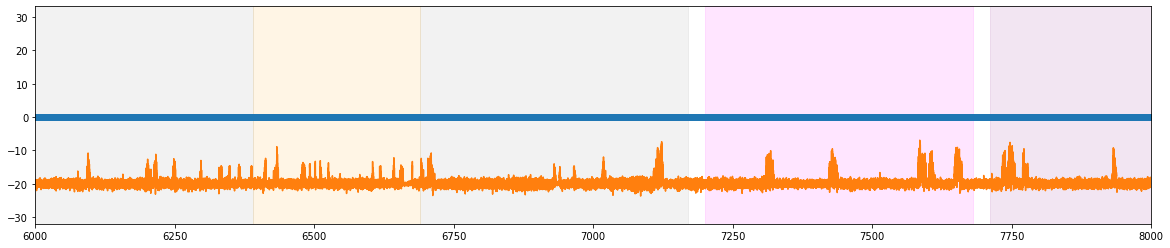

In [29]:
plt.figure(figsize=(20,4))
i=0
plt.plot(spike_times[session.units.index[i]], np.repeat(i,len(spike_times[session.units.index[i]])), '|', alpha=0.5)#, color='gray')
plt.plot(session.running_speed.end_time, (0.4*session.running_speed.velocity)-20)
    
    
colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c,stim_name in enumerate(stimulus_epochs["stimulus_name"].unique()):
    stim = stimulus_epochs[stimulus_epochs["stimulus_name"]==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)
        


plt.xlim(6000,8000)

(6000, 8000)

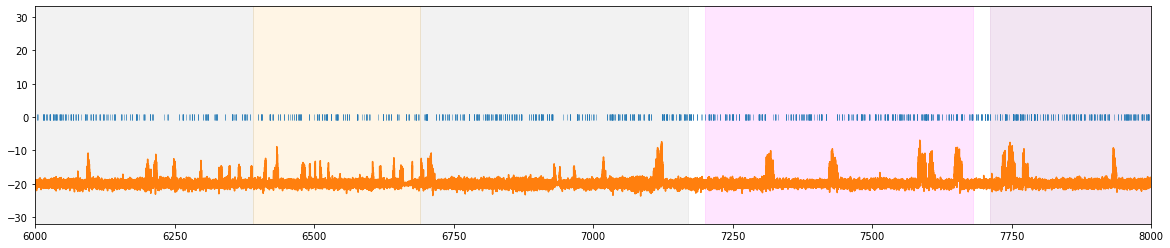

In [30]:
plt.figure(figsize=(20,4))
i=40
plt.plot(spike_times[session.units.index[i]], np.repeat(0,len(spike_times[session.units.index[i]])), '|', alpha=0.5)#, color='gray')
plt.plot(session.running_speed.end_time, (0.4*session.running_speed.velocity)-20)
    
    
colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c,stim_name in enumerate(stimulus_epochs["stimulus_name"].unique()):
    stim = stimulus_epochs[stimulus_epochs["stimulus_name"]==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)
        


plt.xlim(6000,8000)

(6000, 8000)

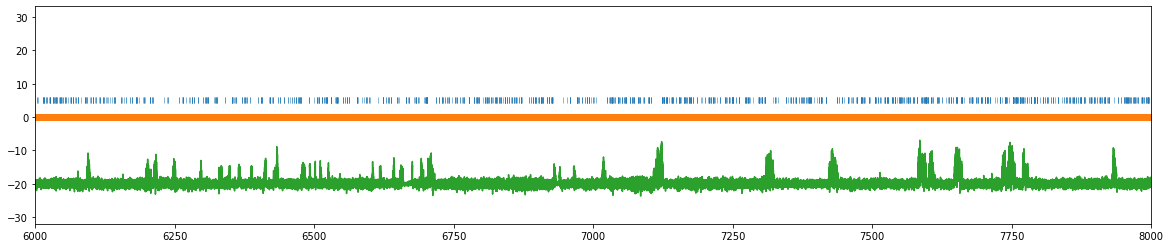

In [31]:
plt.figure(figsize=(20,4))
plt.plot(spike_times[session.units.index[40]], np.repeat(5,len(spike_times[session.units.index[40]])), '|', alpha=0.5)#, color='gray')
plt.plot(spike_times[session.units.index[0]], np.repeat(0,len(spike_times[session.units.index[0]])), '|', alpha=0.5)#, color='gray')
plt.plot(session.running_speed.end_time, (0.4*session.running_speed.velocity)-20)
plt.xlim(6000,8000)

Now let's go back and learn more about the stimulus that was presented. The session object has a function that returns a table for a given stimulus called <b> get_presentations_for_stimulus</b>. Use this to get the stimulus table for drifting gratings.

In [92]:
stim_table = session.get_presentations_for_stimulus('drifting_gratings')

/Users/saskiad/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:810: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: drifting_gratings
  warnings.warn(message)


In [93]:
stim_table.head()

,Contrast,Ori,SF,TF,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,
3798,0.8,315.0,0.04,1.0,1589.92185,2.0,drifting_gratings,1591.92352,2.00167,3798
3799,0.8,225.0,0.04,2.0,1592.92433,2.0,drifting_gratings,1594.92602,2.00169,3799
3800,0.8,135.0,0.04,1.0,1595.92687,2.0,drifting_gratings,1597.92855,2.00168,3800
3801,0.8,180.0,0.04,4.0,1598.92935,2.0,drifting_gratings,1600.93104,2.00169,3801
3802,0.8,90.0,0.04,4.0,1601.93185,2.0,drifting_gratings,1603.93353,2.00168,3802


Now get the stimulus table for natural scenes. What is different about these tables?

In [94]:
stim_table_ni = session.get_presentations_for_stimulus('Natural Images')

/Users/saskiad/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:810: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: Natural Images
  warnings.warn(message)


In [95]:
stim_table_ni.head()

,Image,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51355,96.0,5913.566500,9.0,Natural Images,5913.816705,0.250205,51355
51356,72.0,5913.816705,9.0,Natural Images,5914.066910,0.250205,51356
51357,102.0,5914.066910,9.0,Natural Images,5914.317115,0.250205,51357
51358,55.0,5914.317115,9.0,Natural Images,5914.567320,0.250205,51358
51359,57.0,5914.567320,9.0,Natural Images,5914.817532,0.250213,51359


Let's find all the times when a particular image is presented during the session.  Pick the first image that was presented in this session.

In [98]:
stim_table_ni[stim_table_ni.Image==stim_table_ni.Image.iloc[0]].head()

,Image,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51355,96.0,5913.566500,9.0,Natural Images,5913.816705,0.250205,51355
51642,96.0,5985.376455,9.0,Natural Images,5985.626660,0.250205,51642
51772,96.0,6017.903645,9.0,Natural Images,6018.153850,0.250205,51772
51786,96.0,6021.406540,9.0,Natural Images,6021.656740,0.250200,51786
51972,96.0,6067.945435,9.0,Natural Images,6068.195640,0.250205,51972


How many times was it presented?

In [101]:
len(stim_table_ni[stim_table_ni.Image==stim_table_ni.Image.iloc[0]])

50

Let's mark the times when this stimulus was presented on our plot of the activity, replacing the stimulus epoch shading with shading during this stimulus presentation.

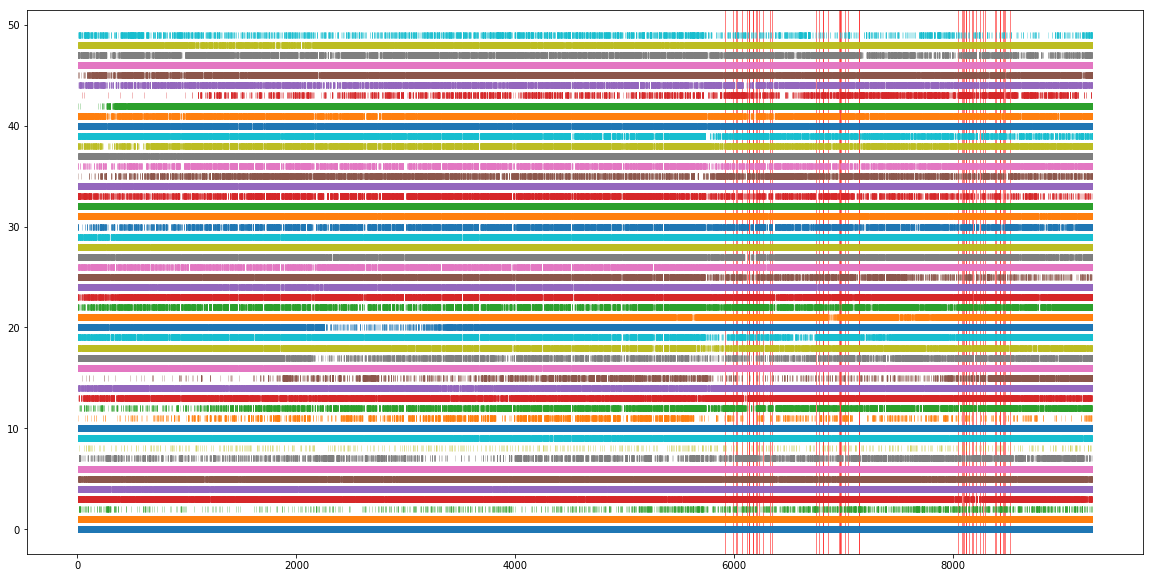

In [107]:
plt.figure(figsize=(20,10))
for i in range(50):
    plt.plot(spike_times[session.units.index[i]], np.repeat(i,len(spike_times[session.units.index[i]])), '|', alpha=0.3)#, color='gray')

stim_subset = stim_table_ni[stim_table_ni.Image==stim_table_ni.Image.iloc[0]]
for j in range(len(stim_subset)):
    plt.axvspan(xmin=stim_subset.start_time.iloc[j], xmax=stim_subset.stop_time.iloc[j], color='r', alpha=0.5)
# plt.xlim(6000,7000)

What is this image? The <b>stimulus template</b> provides the images and movies that were presented to the mouse. These are only provided for stimuli that are images - parametric stimuli (eg. gratings) do not have templates.

In [108]:
session. ### stimulus template here.

SyntaxError: invalid syntax (<ipython-input-108-622d57af0c99>, line 1)

# Exploring units

## Plotting and sorting units

### create a function to plot the raster plot

*** replace with call to api?***

In [32]:
import allensdk.brain_observatory.ecephys.visualization as ecvis
# ecvis.raster_plot()

In [33]:
def plot_raster(spike_times, start, end):
    num_units = len(spike_times)
    ystep = 1 / num_units

    ymin = 0
    ymax = ystep

    for unit_id, unit_spike_times in spike_times.items():
        unit_spike_times = unit_spike_times[np.logical_and(unit_spike_times >= start, unit_spike_times < end)]
        plt.vlines(unit_spike_times, ymin=ymin, ymax=ymax)

        ymin += ystep
        ymax += ystep
        

Select a single stimulus presentation

In [34]:
drifting_gratings_presentation_onsets = session.stimulus_presentations.loc[
    session.stimulus_presentations["stimulus_name"] == "drifting_gratings", 
    "start_time"
].values
start, end = drifting_gratings_presentation_onsets[:2]

In [ ]:
#replace above with using the stimulus table

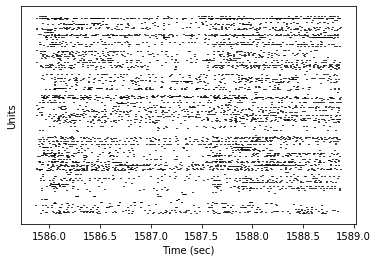

In [35]:
plot_raster(session.spike_times, start, end)
plt.xlabel('Time (sec)')
plt.ylabel('Units')
plt.tick_params(axis="y", labelleft=False, left=False)
plt.show()

### arrange neurons by their firing rate

*** Comments: 1) remove hide the quality column; 2) remove sampling rate column - it is the same!  3) remove valid_data ***

In [36]:
session.units.sort_values(by="firing_rate", ascending=False).head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,channel_local_index,structure_acronym,structure_id,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,lfp_sampling_rate,location,sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,
914622655,0.871902,215.486115,0.000856,31,95.82,6.292358,68.922125,0.005038,188.438973,0.005659,...,50,TH,549.0,59,757904520,520,probeE,2499.999389,,29999.992669
914619093,0.233868,84.936930,0.002083,28,99.36,4.450108,67.937806,0.005373,144.118662,0.002930,...,16,TH,549.0,43,757904508,180,probeA,2499.996858,,29999.962297
914619119,0.550003,98.089290,0.005766,41,93.41,4.223561,63.862635,0.026690,107.960662,0.011313,...,30,TH,549.0,59,757904508,320,probeA,2499.996858,,29999.962297
914619127,0.548529,193.443315,0.000128,45,99.72,7.058351,53.072062,0.001185,111.580873,0.000472,...,33,TH,549.0,11,757904508,340,probeA,2499.996858,,29999.962297
914622665,0.171728,64.157925,0.033602,36,339.02,5.855417,51.866227,0.004061,187.694398,0.000305,...,59,TH,549.0,27,757904520,600,probeE,2499.999389,,29999.992669


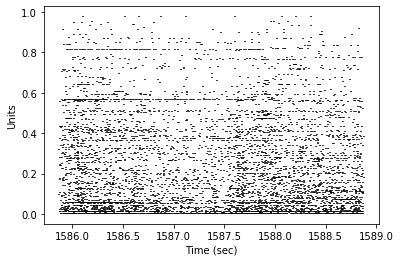

In [37]:
by_fr = session.units.sort_values(by="firing_rate", ascending=False)
spike_times_by_firing_rate = {
    uid: session.spike_times[uid] for uid in by_fr.index.values
}

plot_raster(spike_times_by_firing_rate, start, end)
plt.ylabel('Units')
plt.xlabel('Time (sec)')
plt.show()


## QC Metrics

### show the qc metrics of differnet units

In [38]:
session.units.head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,channel_local_index,structure_acronym,structure_id,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,lfp_sampling_rate,location,sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,
914619047,0.640688,114.786945,0.029609,5,296.84,4.594217,35.326085,0.021893,101.084160,0.007553,...,3,TH,549.0,27,757904508,40,probeA,2499.996858,,29999.962297
914619057,0.590508,74.435595,0.006487,10,496.15,3.043791,21.772278,0.006140,75.417894,0.014093,...,6,TH,549.0,59,757904508,80,probeA,2499.996858,,29999.962297
914619067,1.227057,61.310730,0.024603,15,414.48,2.572846,27.281456,0.009385,84.951087,0.012127,...,8,TH,549.0,43,757904508,100,probeA,2499.996858,,29999.962297
914619079,1.656495,129.899055,0.000788,21,203.89,4.519415,12.407947,0.002521,94.303401,0.000251,...,12,TH,549.0,43,757904508,140,probeA,2499.996858,,29999.962297
914619093,0.233868,84.936930,0.002083,28,99.36,4.450108,67.937806,0.005373,144.118662,0.002930,...,16,TH,549.0,43,757904508,180,probeA,2499.996858,,29999.962297


### narrow down the session parameters

In [39]:
session_params = session.units.loc[:, ["structure_acronym", "probe_id","firing_rate", "isi_violations", "snr",'probe_vertical_position']]
session_params.head()

,structure_acronym,probe_id,firing_rate,isi_violations,snr,probe_vertical_position
unit_id,,,,,,
914619047,TH,757904508,35.326085,0.021893,2.646081,40
914619057,TH,757904508,21.772278,0.006140,1.611303,80
914619067,TH,757904508,27.281456,0.009385,1.676290,100
914619079,TH,757904508,12.407947,0.002521,2.797511,140
914619093,TH,757904508,67.937806,0.005373,2.035620,180


### sort the current session parameters by ISI violations

In [40]:
session_params.sort_values(by="isi_violations").head()

,structure_acronym,probe_id,firing_rate,isi_violations,snr,probe_vertical_position
unit_id,,,,,,
914619673,VIS,757904508,0.591101,0.0,4.608784,2500
914619913,MB,757904510,10.777633,0.0,3.658847,120
914620429,VIS,757904510,1.563949,0.0,6.885239,2820
914619711,VIS,757904508,0.407424,0.0,5.329598,2580
914620857,TH,757904513,9.435535,0.0,6.153970,360


### describe what is the isi violation? write the down the equation for that!
Metrics

1) ISI violation: equation, then plot spike train with the clear spike violation!
2) from Josh: get the ISI, FR etc as metrics where the data is good! what are the thresholds for the good data? SNR + ISI violations

### plot the ISI violation distribution

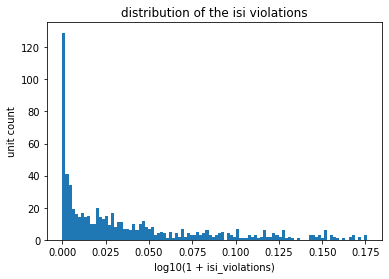

In [41]:
plt.hist(np.log10(1 + session_params["isi_violations"].values), bins=100)
plt.xlabel('log10(1 + isi_violations)')
plt.ylabel('unit count')
plt.title('distribution of the isi violations')
plt.show()

In [42]:
good_units = session_params[
    (session_params["isi_violations"] < 0.2)
    & (session_params["snr"] > 2)
]

print('Number of units with reasonable ISI and SNR:')
print(good_units.shape[0])

Number of units with reasonable ISI and SNR:
396


## Locations of units

### Brain structures

#### describe the area with reasonable qc metrics

In [43]:
good_units.structure_acronym.value_counts()

TH       133
VIS      103
CA        70
VISp      22
MB        20
DG        16
VISrl     15
VISal     12
VISl       5
Name: structure_acronym, dtype: int64


#### plot the firing rate of the units with regards to structures


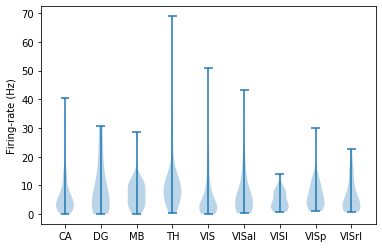

In [44]:
gb = session.units.groupby("structure_acronym")

structures = []
data = []

for group in gb:
    structure, current_data = group
    structures.append(structure)
    data.append(current_data["firing_rate"].values)

axs = plt.gca()
    
plt.violinplot(data)

axs.set_xticks(np.arange(len(structures))+1)
axs.set_xticklabels(structures)
plt.ylabel('Firing-rate (Hz)')
plt.show()


### Locations on probe

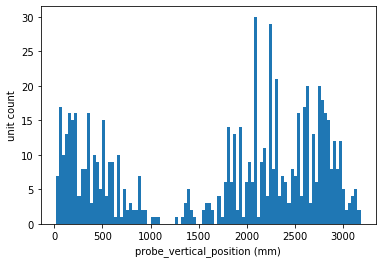

In [45]:
plt.subplots()
plt.hist(session_params["probe_vertical_position"].values, bins=100)
plt.xlabel('probe_vertical_position (mm)')
plt.ylabel('unit count')
plt.show()

## Unit waveforms

In [46]:
# neuropixel probe here! + structure boundaries

In [47]:
waveforms = session.mean_waveforms
type(waveforms)

dict

### Plot all waveforms for one unit

***Add area boundaries here?***

Text(0, 0.5, 'Channel #')

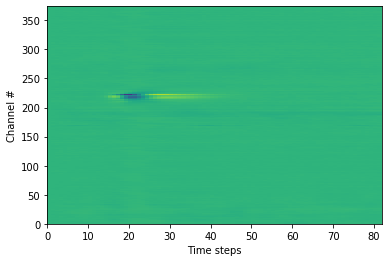

In [48]:
unit = session.units.index.values[400]
wf = session.mean_waveforms[unit]

fig, ax = plt.subplots()
plt.pcolormesh(wf)
plt.xlabel('Time steps')
plt.ylabel('Channel #')

In [49]:
session.units.loc[unit]

PT_ratio                        0.506995
amplitude                        119.416
amplitude_cutoff             4.25957e-05
cluster_id                           267
cumulative_drift                   65.22
d_prime                          10.2861
firing_rate                      30.0545
isi_violations                4.2963e-05
isolation_distance               268.348
l_ratio                      9.09137e-10
local_index_unit                     262
max_drift                          49.22
nn_hit_rate                            1
nn_miss_rate                 0.000331345
peak_channel_id                849748832
presence_ratio                      0.99
recovery_slope                 -0.102675
repolarization_slope            0.535595
silhouette_score               0.0718796
snr                              4.75981
spread                                60
velocity_above                  0.343384
velocity_below                 -0.549414
waveform_duration               0.247236
waveform_halfwid

### plot peak channels for all units recorded in the dentate gyrus (DG)

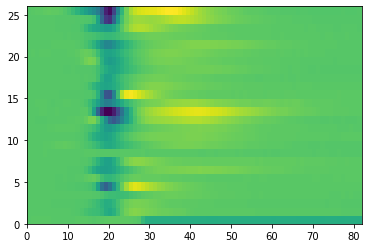

In [50]:
fig, ax = plt.subplots()

th_unit_ids = session.units[session.units["structure_acronym"] == "DG"].index.values

peak_waveforms = []

for unit_id in th_unit_ids:

    peak_ch = session.units.loc[unit_id, "peak_channel_id"]
    unit_mean_waveforms = session.mean_waveforms[unit_id]

    peak_waveforms.append(unit_mean_waveforms.loc[{"channel_id": peak_ch}])
    
    
time_domain = unit_mean_waveforms["time"]

peak_waveforms = np.array(peak_waveforms)
plt.pcolormesh(peak_waveforms)

### show the pca of the average waveforms to make sure the units make sense

***Check whether we want this here or in exercises***

In [51]:
# apply pca to the averaged waveforms

# from sklearn import decomposition
# pca = decomposition.PCA(n_components=2)
# pca.fit(peak_waveforms)


In [52]:
# fig, ax = plt.subplots()
# plt.plot(time_domain, pca.components_.T)
# plt.title('2 PCA components')


# print('Explained variance of 2 components')
# print(pca.explained_variance_ratio_)

# Spike histograms and stimulus coding

***Maybe modify to use stim rather than spontaneous to transition into stim coding?***

### create the histograms

In [53]:
spon = session.stimulus_presentations.loc[
    session.stimulus_presentations["stimulus_name"] == "spontaneous_activity", 
    ["start_time", "stop_time"]
]

In [54]:
first_spon_id = spon.index.values[0]
first_spon_duration = spon.loc[first_spon_id, "stop_time"] - spon.loc[first_spon_id, "start_time"]

# 1 - sec
time_step = 1 / 100
time_domain = np.arange(0.0, first_spon_duration + time_step, time_step)

histograms = session.presentationwise_spike_counts(
    bin_edges=time_domain,
    stimulus_presentation_ids=spon.index,
    unit_ids=None
)

print(histograms)

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 15, time_relative_to_stimulus_onset: 6007, unit_id: 696)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[1, 1, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [2, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 1, ..., 1, 0],
        [1, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [1, 1, ..., 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 0 ... 68229
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.005 ... 60.06
  * unit_id                          (unit_id) int64 914619047 ... 914624325


### plot the firing rate of neurons in different units

Text(0.5, 0, 'Time (sec)')

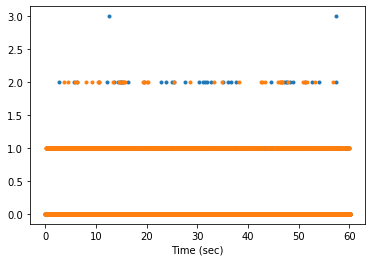

In [55]:
# spike_counts = histograms.spike_counts.values
time = histograms["time_relative_to_stimulus_onset"]

hist_train_1 = histograms[0,:,0]
hist_train_2 = histograms[0,:,1]

fig, ax = plt.subplots()

plt.plot(time, hist_train_1, '.')
plt.plot(time, hist_train_2, '.')
plt.xlabel('Time (sec)')

### compute the mean of the histograms

In [56]:
mean_histograms = histograms.mean(dim="stimulus_presentation_id")

In [57]:
mean_histograms.coords

Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.005 ... 60.06
  * unit_id                          (unit_id) int64 914619047 ... 914624325

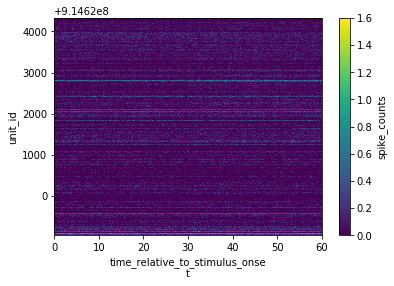

In [58]:
import xarray.plot as xrplot
xrplot.imshow(darray=mean_histograms, x="time_relative_to_stimulus_onset",
                                      y="unit_id")

### compute the correlation matrix

***Move this part to exercises?? operate on means or by trial??***

***also this is very slow!***

In [59]:
# spike_counts = mean_histograms
# num_units = spike_counts.shape[1]

# correlations = np.zeros((num_units, num_units))

# for ii in range(num_units):
#     for jj in range(num_units):
#         # normalize spike trains before computation
#         spike_train_1=spike_counts[:, ii]
# #        spike_train_1=(spike_train_1-np.mean(spike_train_1))/np.std(spike_train_1)/len(spike_train_1)
#         spike_train_2=spike_counts[:, jj]
# #        spike_train_2=(spike_train_2-np.mean(spike_train_2))/np.std(spike_train_2)/len(spike_train_2)
#         correlations[ii, jj] = np.correlate(spike_train_1, spike_train_2)
# #        np.correlate(spike_counts[:, ii], spike_counts[:, jj])

In [60]:
# fig, ax = plt.subplots()
# plt.imshow(np.log10(correlations+1))

## Stimulus coding

***Construct a basic tuning curve***

We can access summary spike statistics for stimulus conditions and unit. This can be slow to compute, so we'll restrict to a small number of units, and one stimulus type.

In [61]:
presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

n_units = 20
unit_ids = session.units.sort_values('snr', ascending=False).index.values[:n_units]

In [62]:
stats = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=presentation_ids,
    unit_ids=unit_ids
)
stats.head()

,,spike_count,spike_mean,spike_sem,spike_std,stimulus_presentation_count
unit_id,stimulus_condition_id,,,,,
914619523,246,1330,88.666667,6.358097,24.624804,15
914619677,246,4,0.266667,0.153271,0.593617,15
914619727,246,58,3.866667,1.372751,5.316641,15
914619737,246,26,1.733333,1.097472,4.250490,15
914620211,246,18,1.200000,0.857460,3.320929,15


In [63]:
# display the parameters associated with each condition
conditions_stats = pd.merge(stats, session.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)
conditions_stats.head()

,,spike_count,spike_mean,spike_sem,spike_std,stimulus_presentation_count,Color,Contrast,Image,Ori,Phase,Pos_x,Pos_y,SF,TF,stimulus_name
unit_id,stimulus_condition_id,,,,,,,,,,,,,,,
914619523,246,1330,88.666667,6.358097,24.624804,15,null,0.8,null,180,null,null,null,0.04,4,drifting_gratings
914619677,246,4,0.266667,0.153271,0.593617,15,null,0.8,null,180,null,null,null,0.04,4,drifting_gratings
914619727,246,58,3.866667,1.372751,5.316641,15,null,0.8,null,180,null,null,null,0.04,4,drifting_gratings
914619737,246,26,1.733333,1.097472,4.250490,15,null,0.8,null,180,null,null,null,0.04,4,drifting_gratings
914620211,246,18,1.200000,0.857460,3.320929,15,null,0.8,null,180,null,null,null,0.04,4,drifting_gratings


Using these data, we can ask for each unit: which stimulus condition evoked the most activity on average?

In [64]:
highest_mean_rate = lambda df: df.loc[df['spike_mean'].idxmax()]
max_rate_conditions = conditions_stats.groupby('unit_id').apply(highest_mean_rate)
max_rate_conditions.head()

,spike_count,spike_mean,spike_sem,spike_std,stimulus_presentation_count,Color,Contrast,Image,Ori,Phase,Pos_x,Pos_y,SF,TF,stimulus_name
unit_id,,,,,,,,,,,,,,,
914619523,1847,123.133333,9.431390,36.527615,15,null,0.8,null,0,null,null,null,0.04,8,drifting_gratings
914619677,16,1.066667,0.511456,1.980861,15,null,0.8,null,135,null,null,null,0.04,2,drifting_gratings
914619727,271,18.066667,3.635102,14.078690,15,null,0.8,null,45,null,null,null,0.04,2,drifting_gratings
914619737,97,6.466667,3.287591,12.732785,15,null,0.8,null,90,null,null,null,0.04,4,drifting_gratings
914620211,114,7.600000,3.098079,11.998809,15,null,0.8,null,225,null,null,null,0.04,8,drifting_gratings


## Local Field Potential (LFP)

The final aspect of a Neuropixels probe recording we will investigate is the local field potential (LFP). An LFP signal is a direct recordings of extracellular voltage from which individual spike contributions have been removed by low-pass filtering. The remaining signal reflects the population activity of a large number of cells in the vicinity of the probe, primarily through the electrical field effects of synaptic currents (along with other trans-membrane currents).

LFP can be especially informative for understanding rhythmic activity or oscillations in neural circuits, which can be identified by some simple time-series analysis of the LFP signals.

### Accessing data

We'll start by loading the LFP data from one of the probes in our session.

We need to provide this function with a probe id, which we can pull out of the `session.probes` table. 

(Note that the "id" column is the index of the dataframe, and thus must be accessed differently than other columns.)

In [65]:
probe_id = session.probes.index[0]
lfp = session.get_lfp(probe_id)
print(lfp)

<xarray.DataArray 'LFP' (time: 12072812, channel: 82)>
array([[ 289,  221,  257, ...,   31,  -25,  -17],
       [ 226,    6,   89, ...,  -33, -193,  111],
       [ 366,  143,  251, ...,  -23, -104,  129],
       ...,
       [ 132,  -44, -373, ..., -159, -233,    2],
       [ 157,  175, -284, ..., -151, -295,   68],
       [  97,  129,  -94, ...,  -59, -116,    3]], dtype=int16)
Coordinates:
  * time     (time) float64 3.741 3.741 3.742 ... 9.662e+03 9.662e+03 9.662e+03
  * channel  (channel) int64 849743022 849743030 ... 849743662 849743670


### Plot the LFP time series

To visualize this data, we'll first use the built-in xarray plotting to generate a quick plot. This is too much data to plot all at once, so we select a subset first. Just as in pandas, we use the `loc` property, but since xarray has named dimensions, we can specify our selections by name rather than by order, using a dict.

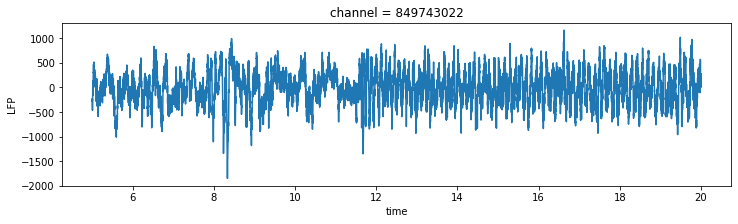

In [66]:
channel = lfp.channel[0]
lfp_subset = lfp.loc[dict(channel=channel, time=slice(5,20))]

plt.figure(figsize=(12,3))
lfp_subset.plot()

We might also want to visualize a specific frequency band by filtering. To do this we'll want to convert our data into standard numpy arrays for easier processing using the DataArray object's `values` property.

In [67]:
t = lfp_subset.time.values
v = lfp_subset.values

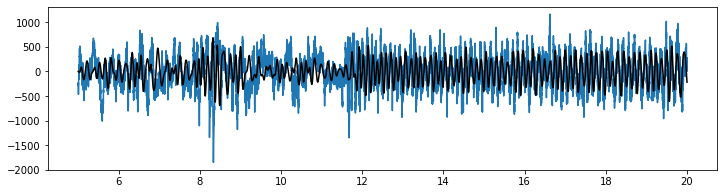

In [68]:
import scipy.signal
freq_window = (4, 10)
filt_order = 3
fs = 1/(t[1]-t[0])
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)
v_alpha = scipy.signal.lfilter(b, a, v)


plt.figure(figsize=(12,3))
plt.plot(t, v)
plt.plot(t, v_alpha,'k')

## Spectral analysis


Next we're going to analyze some spectral properties of this signal using the `scipy.signal` library. "Spectral" refers to decomposing a signal into a sum of simpler components identified by their frequencies. The set of frequencies of the components forms a *spectrum* that tells us about the complete signal. You can see a full list of spectral analysis functions in scipy here: https://docs.scipy.org/doc/scipy/reference/signal.html#spectral-analysis

### Power spectral density (PSD)

We first import the package, and inspect the `periodogram` function, which estimates the size of the different frequency components of the signal.

** Note: maybe we want to compute this directly from an FFT? but only if that concept is already meaningful, so maybe not...**

In [69]:
import scipy.signal
help(scipy.signal.periodogram)

Help on function periodogram in module scipy.signal.spectral:

periodogram(x, fs=1.0, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
    Estimate power spectral density using a periodogram.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length must be nperseg. Defaults
        to 'boxcar'.
    nfft : int, optional
        Length of the FFT used. If `None` the length of `x` will be
        used.
    detrend : str or function or `

There are a number of options that we won't go into here for refining the analysis. The one piece of information we do need is `fs`, the sampling frequency. If we used the default value `fs=1.0` our results would not match the true frequencies of the signal.

In [70]:
fs = 1/(t[1]-t[0])

f, psd = scipy.signal.periodogram(v, fs)

We'll plot the power spectrum on a semilog plot, since power can vary over many orders of magnitude across frequencies.

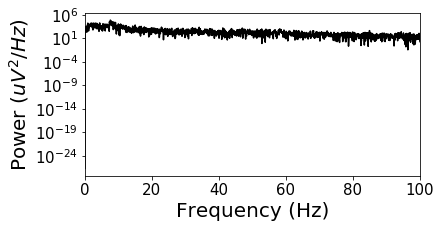

In [71]:
plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,100))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.show()

We see that this representation of the power spectrum is extremely noisy. Luckily, many people have come up with solutions to this problem. Scipy includes a function for Welch's method, which averages out noise by computing many estimates of the power spectrum from overlapping windows of the data. You can find some more references for this approach in the Scipy documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch

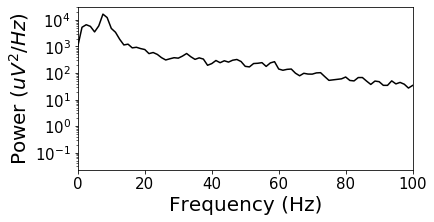

In [72]:
f, psd = scipy.signal.welch(v, fs, nperseg=1000)

plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,100))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.show()

### Calculate and plot the time-frequency profile ("spectrogram")

We might also be interested in how the frequency content of the signal varies over time. In a neural context, power in different frequency bands is often linked to specific types of processing, so we might explore whether changes in the spectrum coincide with specific behaviors or stimuli.

The *spectrogram* is essentially an estimate of the power spectrum computed in a sliding time window, producing a 2D representation of the signal power across frequency and time.

In [73]:
f, t_spec, spec = scipy.signal.spectrogram(v, fs=fs, window='hanning',
                            nperseg=1000, noverlap=1000-1, mode='psd')
# Scipy assumes our signal starts at time=0, so we need to provide the offset
t_spec = t_spec + t[0]

We'll use the matplotlib `pcolormesh` function to visualize this data as an image. We can pass this function x and y coordinates to get the axis labeling right. We also log-transform the power spectrum and restrict to frequencies less than 100 Hz.

In [74]:
fmax = 80
x, y = t_spec, f[f<fmax]
plot_data = np.log10(spec[f<fmax])

We'll plot the spectrum together with the raw signal in subplots. Note that we explicitly set the x-axis limits to align the plots. (Alternatively, it's possible to directly couple the limits of different subplots.)

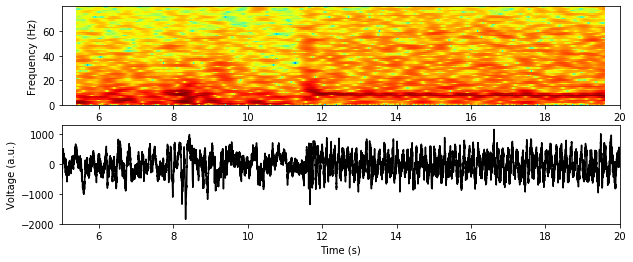

In [75]:
from matplotlib import cm
plt.figure(figsize=(10,4))

plt.subplot(2,1,1)
plt.pcolormesh(x, y, plot_data, cmap=cm.jet)
window = [5,20]
plt.xlim(window)
plt.ylabel('Frequency (Hz)')

plt.subplot(2,1,2)
plt.plot(t, v, 'k')
plt.xlim(window)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')
plt.show()

## Current source density (CSD) analysis

Physically, the LFP is made up of the electric fields from specific current sources (or sinks) in brain tissue, namely individual trans-membrane currents. Under certain simplifying assumptions, this transformation of spatial current distribution into field potential can be inverted to infer the distribution of currents underlying a measurement. This is called the current source density, or CSD. Spatial properties of the LFP are generally better studied in this representation.

We will use a built-in method to calculate the CSD at a strip of positions down the center of the probe.

In [76]:
csd = session.get_current_source_density(probe_id)
csd

<xarray.DataArray 'CSD' (channel: 160, time: 3250)>
array([[ 13094.963942,  17118.401442,  22821.526442, ...,  11493.401442,
         20243.401442, -15694.098558],
       [  1959.038462,   7818.413462,  -7728.461538, ...,  -3900.336538,
          4341.850962,   7505.913462],
       [-18226.610577, -18421.923077, -22289.110577, ...,   1382.764423,
          -531.298077,  18335.889423],
       ...,
       [ -1608.930288,   1906.694712,  -3952.680288, ...,   3391.069712,
           969.194712,  -2038.617788],
       [  3475.084135,   4021.959135,   2303.209135, ...,  -7813.978365,
         -9884.290865, -15079.603365],
       [ -3544.194712,  -6630.132212, -12372.319712, ...,  -2372.319712,
          2783.930288,   3174.555288]])
Coordinates:
  * channel  (channel) uint64 849743026 849743030 ... 849743658 849743662
  * time     (time) float64 -0.3 -0.2996 -0.2992 ... 0.9988 0.9992 0.9996

In [ ]:
# pass in the list of channels from the CSD
channels = session.channels.loc[csd.channel]
structure_acronyms, intervals = ecephys_session.intervals_structures(channels)
interval_midpoints = [ (aa + bb) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]

NameError: name 'intervals' is not defined

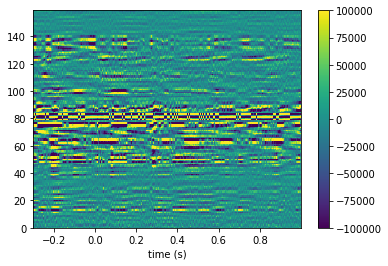

In [77]:
fig, ax = plt.subplots()

x, y = csd.time, range(len(csd.channel))
plt.pcolormesh(x, y, csd, vmin=-1e5, vmax=1e5)
plt.colorbar(ax=ax)

ax.set_xlabel("time (s)")
ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)

plt.tick_params("y", which="major", labelleft=False, length=40)
plt.show()